# Build predictive Business Intelligence with Google Colab, Google Data Studio and Google Sheets

Many of us are used to think that Business Intelligence is something that large companies use and that is created with tools that are expensive and often difficult to learn (although there are pleasant exceptions, such as Metabase and Superset). In my article I want to show that practically everyone can use the power of Business Intelligence, and even add some Predictive Analytics to it with generally available and free online tools, such as Google Colab and Google Data Studio. Database deployment is not required. All data for analysis and visualization we will store in Google Sheets.

We will implement a machine learning model in Google Colab and based on the sales history of the products we will be able to predict future sales for several months and visualize our prediction in Google Data Studio. 

We will use the dataset with information about the list of products and the sales history for 12 months for each product. 

The model will analyze the sales history and changes in product features for each month, so that any change will dynamically affect the model predictions. This will allow us to quickly assess the consequences of certain decisions and adopt an optimal development strategy.



## Load Data

We consider, that all operations we do in Google Colab. First of all we will use **kaggle** module to download needed dataset. You can read in more detail about module and how to get Kaggle API Token by this [link](https://github.com/Kaggle/kaggle-api)

**Dataset description (https://www.kaggle.com/c/online-sales/data):**

*We have the data in the comma separated values (CSV) format.  Each row in this data set represents a different consumer product.*

*The first 12 columns (Outcome_M1 through Outcome_M12) contains the monthly online sales for the first 12 months after the product launches. *

*Date_1 is the day number the major advertising campaign began and the product launched.  *

*Date_2 is the day number the product was announced and a pre-release advertising campaign began.*

*Other columns in the data set are features of the product and the advertising campaign.  Quan_x are quantitative variables and Cat_x are categorical variables. Binary categorical variables are measured as (1) if the product had the feature and (0) if it did not.*

In [ ]:
!pip install kaggle

As we are using Google Colab, we will connect to Google Drive to copy Kaggle credentials.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks")

Copy credentials for Kaggle API.

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json

Download dataset.

In [ ]:
!kaggle competitions download -c online-sales

TestDataset.csv: Skipping, found more recently modified local copy (use --force to force download)
TrainingDataset.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission_using_training_column_means.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_code.R: Skipping, found more recently modified local copy (use --force to force download)


Load the dataset in the memory and explore its shape (number of rows and columns).

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
df = pd.read_csv("TrainingDataset.csv")

In [ ]:
df.shape

(751, 558)

Test it on the presence of the null values.

In [ ]:
df.isnull().values.any()

For our purposes we can just replace null values with zeroes.

In [ ]:
df = df.replace(np.nan, 0, regex=True)
df.isnull().values.any()

False

Now we can preview the dataset.

In [ ]:
df.iloc[:, 0:15].tail(10)

,Outcome_M1,Outcome_M2,Outcome_M3,Outcome_M4,Outcome_M5,Outcome_M6,Outcome_M7,Outcome_M8,Outcome_M9,Outcome_M10,Outcome_M11,Outcome_M12,Cat_1,Date_1,Quan_1
741,24000,31000.0,5000.0,3000.0,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0,500.0,1,2142,1263700
742,2000,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,2,2681,1252200
743,21000,15000.0,6000.0,3000.0,3000.0,2000.0,2000.0,2000.0,3000.0,2000.0,2000.0,500.0,2,3038,1979900
744,23000,3000.0,3000.0,6000.0,2000.0,2000.0,2000.0,500.0,500.0,500.0,500.0,500.0,1,2072,1080000
745,16000,3000.0,2000.0,2000.0,500.0,500.0,2000.0,500.0,500.0,500.0,500.0,500.0,1,1988,922700
746,45000,35000.0,6000.0,3000.0,3000.0,2000.0,2000.0,2000.0,2000.0,2000.0,3000.0,500.0,2,3339,2613200
747,2000,2000.0,2000.0,500.0,500.0,500.0,500.0,500.0,2000.0,500.0,2000.0,500.0,2,2302,685300
748,10000,2000.0,500.0,500.0,500.0,2000.0,3000.0,500.0,2000.0,500.0,2000.0,500.0,1,2347,1684000
749,11000,3000.0,2000.0,2000.0,2000.0,500.0,500.0,500.0,2000.0,2000.0,500.0,500.0,2,2618,1210500
750,18000,6000.0,2000.0,2000.0,2000.0,2000.0,2000.0,500.0,2000.0,2000.0,2000.0,3000.0,1,2569,2281200


We will split our dataset into the training part (on which we will train our model) and the test part (on which we will test the correctness of our model)

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2)
print(df_train.shape)
print(df_test.shape)

(600, 558)
(151, 558)


## Exploratory Data Analysis 

Let's visualize our data. We will show the price change dynamics for 10 random products.

In [ ]:
import random

indexes = random.sample(range(len(df)), 10)
indexes

[638, 239, 361, 534, 101, 318, 258, 666, 563, 143]

In [ ]:
df_plot = pd.DataFrame()

for i in indexes:
  df_plot["product_"+str(i)] = df.iloc[i, 0:12]

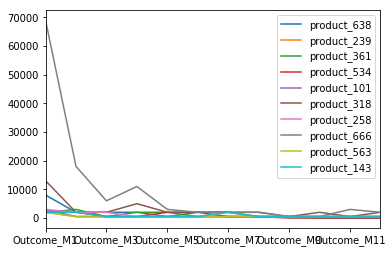

In [ ]:
df_plot.plot();

As we see, sales are  declining throughout the year in most cases.

## Prepare data

We need to prepare our data in a special way to load into our model. We will build a model that forecasts future month outcome based on previous values. For each month model will analyze product features and information about previous month outcome.

In [ ]:
# firstly, we will separate product features and information about outcome per month

y_train_real = df_train.iloc[:, 0:12].values
print(y_train_real.shape)

y_test_real = df_test.iloc[:, 0:12].values
print(y_test_real.shape)

(600, 12)
(151, 12)


In [ ]:
x_train_real = df_train.iloc[:, 12:].values
x_test_real = df_test.iloc[:, 12:].values
print(x_train_real.shape)
print(x_test_real.shape)

(600, 546)
(151, 546)


In [ ]:
# scale values in one range for better predictions

from sklearn.preprocessing import MinMaxScaler

#scale datasets
x_scaler = MinMaxScaler()
x_scaler = x_scaler.fit(x_train_real)
x_train = x_scaler.transform(x_train_real)
x_test = x_scaler.transform(x_test_real)

y_scaler = MinMaxScaler()
y_scaler = y_scaler.fit(y_train_real)
y_train = y_scaler.transform(y_train_real)
y_test = y_scaler.transform(y_test_real)


Now let us move to the most important step of this process: convert price history to multidimensional time series. For each product we will create TimeSeries with 1-12 timesteps with information about product features and previous timestep outcome. We do not know previous outcome for first timestep, so we will just take zero.

In [ ]:
# Here we create lists for training and test data, each list will contain 12 3-dimensional numpy arrays. 
# Second dimension for each array will represent timesteps and gradually increases by 1. 

x_train_series = []
x_test_series = []

for k in range(len(y_train[0])):
  x_train_series.append(np.zeros((x_train.shape[0], k+1, x_train.shape[1]+1)))

for k in range(len(y_test[0])):
  x_test_series.append(np.zeros((x_test.shape[0], k+1, x_test.shape[1]+1)))
  

In [ ]:
# Add to each timestep information about product features and previous timestep outcome.
# Now we are using the same product features for each timestep, 
# but the model allows to track features changes on each timestep 
# to make more accurate predictions.

for k in range(len(y_train[0])):
  for i in range(len(x_train)):
    for j in range(k + 1):
      shifted_index = j - 1
      if shifted_index < 0:
        x_train_series[k][i, j] = np.append(x_train[i], 0)
      else:
        x_train_series[k][i, j] = np.append(x_train[i], y_train[i, shifted_index])

In [ ]:
# The same timesteps conversion for test data.

for k in range(len(y_test[0])):
  for i in range(len(x_test)):
    for j in range(k + 1):
      shifted_index = j - 1
      if shifted_index < 0:
        x_test_series[k][i, j] = np.append(x_test[i], 0)
      else:
        x_test_series[k][i, j] = np.append(x_test[i], y_test[i, shifted_index])

In [ ]:
# Make 12 lists with information about outcome per TimeSerie, per product.

y_train_series = []
y_test_series = []

for k in range(len(y_train[0])):
  y_train_series.append(np.zeros((len(y_train), 1)))
  y_test_series.append(np.zeros((len(y_test), 1)))
 
  
for k in range(len(y_train[0])):
  y_train_series[k] = y_train[:, k].reshape(-1, 1)
  y_test_series[k] = y_test[:, k].reshape(-1, 1)
  

Review our lists with TimeSeries

In [ ]:
print(x_train_series[0].shape)
print(x_test_series[0].shape)
print(x_train_series[11].shape)
print(x_test_series[11].shape)

(600, 1, 547)
(151, 1, 547)
(600, 12, 547)
(151, 12, 547)


In [ ]:
print(y_train_series[0].shape)
print(y_test_series[0].shape)
print(y_train_series[11].shape)
print(y_test_series[11].shape)

(600, 1)
(151, 1)
(600, 1)
(151, 1)


## Building LSTM Neural Network

We will use long short term memory (LSTM) network of the Recurrent neural network (RNN). You can read more about these types of NN here:

* https://deeplearning4j.org/lstm.html
* http://colah.github.io/posts/2015-08-Understanding-LSTMs/

We use Keras framework for deep learning. Our model consists of just one LSTM layer with 256 units, one Dense layer with 128 units and the densely connected output layer with one neuron. We also added one Dropout layer to avoid overfitting. Model stays simple and quick, still able to make useful predictions.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [ ]:
model = Sequential()
model.add(LSTM(256, input_shape=(None, x_train.shape[1]+1)))
model.add(Dropout(0.5))
model.add(Dense(128, activation = "relu"))
model.add(Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 256)               823296    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 856,321
Trainable params: 856,321
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mse', optimizer='rmsprop')

In [ ]:
# use %timeit to measure learning time on standard Google Colab instance

%%timeit -r 1 -n 1
for i in range(len(x_train_series)):
  print(i)
  model.fit(x_train_series[i], y_train_series[i], epochs=10, validation_split=0.2)

In [ ]:
## Evaluate model for prediction of outcome after several months

for i in range(len(x_test_series)):
  accr = model.evaluate(x_test_series[i], y_test_series[i])
  print("Predicting outcome after {} months. MSE:".format(i), accr)

151/151 [==============================] - 0s 128us/step
Predicting outcome after 0 months. MSE: 0.010366628150030083
151/151 [==============================] - 0s 84us/step
Predicting outcome after 1 months. MSE: 0.008765583182530885
151/151 [==============================] - 0s 99us/step
Predicting outcome after 2 months. MSE: 0.008588158744479844
151/151 [==============================] - 0s 110us/step
Predicting outcome after 3 months. MSE: 0.006344354214973205
151/151 [==============================] - 0s 127us/step
Predicting outcome after 4 months. MSE: 0.007653137693638044
151/151 [==============================] - 0s 169us/step
Predicting outcome after 5 months. MSE: 0.007342025674632843
151/151 [==============================] - 0s 150us/step
Predicting outcome after 6 months. MSE: 0.008044605565855636
151/151 [==============================] - 0s 169us/step
Predicting outcome after 7 months. MSE: 0.006842109683086935
151/151 [==============================] - 0s 181us/step
P

In [ ]:
prediction = model.predict(x_test_series[11])
prediction.shape

(151, 1)

## Outcome prediction function

We will use our model to create a function that will take information about product features and outcome history during several months. As a result this function will predict future outcome for as many months as you wish. 

In [ ]:
# our function will take information about outcome during first m months and predict outcome for future months

def predictor(features, history, future):
  '''
  features: list of product features
  history: list with outcome per month
  future: int, number of months to predict outcome
  '''
  if future == 0:
    return history  
  
  p_serie = np.zeros((1, len(history), len(features)+1))  
  
  for j in range(len(history)):
    shifted_index = j - 1
    if shifted_index < 0:
      p_serie[0, j] = np.append(features, 0)
    else:
      p_serie[0, j] = np.append(features, history[shifted_index])
      
  prediction = model.predict(p_serie)    
  
  history.append(prediction[0][0])
  future -= 1  
  
  return predictor(features, history, future)

In [ ]:
# we will test our function on a random product n
# we will create two lists. First with outcome history for first m months, second with product features

import random

n = random.choice(range(len(x_test)-1))
m = 6
future = 6

features = x_test[n].tolist()
history = y_test[n, 0:m].tolist()

print("Features: ", features[0:5])
print("Scaled outcome history: ", history)

Features:  [1.0, 0.6532507739938082, 0.33716511676755334, 0.7604166666666667, 0.4594594594594595]
Scaled outcome history:  [0.005044136191677175, 0.006349206349206349, 0.004629629629629629, 0.006756756756756756, 0.024691358024691357, 0.018518518518518517]


In [ ]:
prediction = predictor(features, history, future)
# print(prediction)
# print(y_test[n, :m+future])

In [ ]:
y_scaler.inverse_transform([prediction])

array([[6000.        , 2000.        ,  500.        ,  500.        ,
        2000.        ,  500.        ,  961.77857369,  873.31070378,
         896.80594951,  862.35129088,  367.66000092,  365.23140967]])

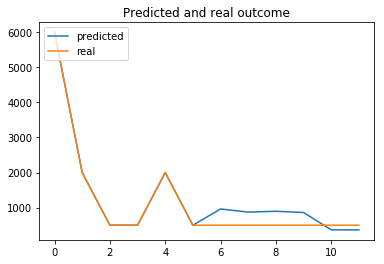

In [ ]:
# plot results of prediction comparing real data
plt.plot(y_scaler.inverse_transform([prediction])[0])
plt.plot(y_scaler.inverse_transform([y_test[n, :m+future]])[0])
plt.title('Predicted and real outcome')
plt.legend(['predicted', 'real'], loc='upper left')
axes = plt.gca()

plt.show()

As we can see, our predicted values are close to real values.
Let's try several other random products.

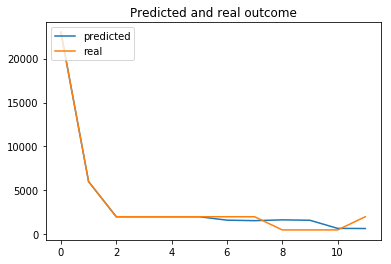

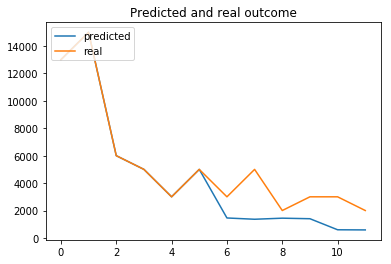

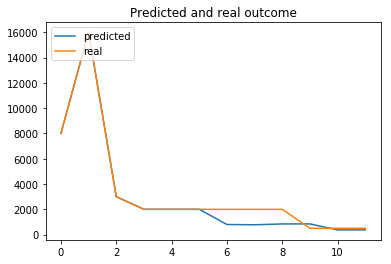

In [ ]:
for i in range(3):
  n = random.choice(range(len(x_test)-1))
  m = 6
  future = 6
  features = x_test[n].tolist()
  history = y_test[n, 0:m].tolist()

  prediction = predictor(features, history, future)

  # plot results of prediction comparing real data
  plt.plot(y_scaler.inverse_transform([prediction])[0])
  plt.plot(y_scaler.inverse_transform([y_test[n, :m+future]])[0])
  plt.title('Predicted and real outcome')
  plt.legend(['predicted', 'real'], loc='upper left')
  axes = plt.gca()  
  plt.show()

As we can see it quite accurately showed sales change overall trend. Not bad result for a comparably simple model.

## Display predictions in Google Data Studio

Now, when we have our predicted data, we can display it in Google Data Studio (https://datastudio.google.com/), a Google's Business Intelligence solution. One of the advantages of this tool is that it can be used for free to make custom reports and dashboards.

Google Data Studio can connect multiple data sources for reporting. Google Sheets as data source is suitable for our purposes. We will save our predictions as a Google Sheet, and Google Data Studio will display the data from it on the dashbord. Thus, we can easily integrate Google Collaboratory and Data Studio.

I will not explain in detail Google Data Studio functionality. You can learn about it in the official documentation https://developers.google.com/datastudio/


We will take three random products, save predictions and outcome history for each.
To save our data to Google Spreadsheet we will use **gspread** library.

Wee will need a client key to write on a Google Spreadsheet. How to get the key is described here https://gspread.readthedocs.io/en/latest/oauth2.html.


In [ ]:
!pip install --upgrade oauth2client gspread

Requirement already up-to-date: oauth2client in /usr/local/lib/python3.6/dist-packages (4.1.3)
  Found existing installation: gspread 3.0.1
    Uninstalling gspread-3.0.1:
      Successfully uninstalled gspread-3.0.1


In [ ]:
# Connect to Google Sheets

import gspread
from oauth2client.service_account import ServiceAccountCredentials

scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

credentials = ServiceAccountCredentials.from_json_keyfile_name('spreadkey.json', scope)

gc = gspread.authorize(credentials)

Make lists with real and predicted outcome history for three random products.
For testing purposes we are using data from test dataset, but in real scenario you can insert any changes of product features in Google Sheets, load data from Google Sheets and make a prediction.

In [ ]:
real_data = []
predicted_data = []

for i in range(3):
  n = random.choice(range(len(x_test)-1))
  m = 6
  future = 6
  features = x_test[n].tolist()
  history = y_test[n, 0:m].tolist()

  prediction = predictor(features, history, future)

  predicted_data.append(y_scaler.inverse_transform([prediction])[0])
  real_data.append(y_scaler.inverse_transform([y_test[n, :m+future]])[0])  

In [ ]:
# Open Google Sheet for saving real and predicted data. 
# We have two worksheets in it: "real" for real data, "predicted" for predicted data.

ws = gc.open('TrainingDataset2')

ws_predicted = ws.worksheet("predicted")
ws_real = ws.worksheet("real")

In [ ]:
predicted_data[0]

array([31000.        ,  3000.        ,  2000.        ,  2000.        ,
         500.        ,  2000.        ,  1038.33638504,   938.46688047,
         932.24851787,   851.54785961,   340.53198993,   315.30641019])

In [ ]:
# Write our real and predicted data to Google Sheets.
# We will write starting from  the second row, reserving first row for column names(Product1, Product2, Product3)

for j in range(len(real_data)):
  for i in range(len(real_data[0])):
    ws_predicted.update_cell(i+2, j+1, float(predicted_data[j][i]))
    ws_real.update_cell(i+2, j+1, float(real_data[j][i]))
    
    
for i in range(len(real_data[0])):    
    # add index column
    ws_predicted.update_cell(i+2, len(real_data)+1, i)
    ws_real.update_cell(i+2, len(real_data)+1, i)

In [ ]:
# Review our data at Google Sheets

ws_real.get_all_records()[6:11]

[{'Index': 6, 'Product1': 2000, 'Product2': 500, 'Product3': 500},
 {'Index': 7, 'Product1': 500, 'Product2': 2000, 'Product3': 500},
 {'Index': 8, 'Product1': 500, 'Product2': 500, 'Product3': 500},
 {'Index': 9, 'Product1': 2000, 'Product2': 500, 'Product3': 500},
 {'Index': 10, 'Product1': 500, 'Product2': 500, 'Product3': 500}]

In [ ]:
ws_predicted.get_all_records()[6:11]

[{'Index': 6,
  'Product1': 1038.336385,
  'Product2': 1005.46407,
  'Product3': 891.3028389},
 {'Index': 7,
  'Product1': 938.4668805,
  'Product2': 888.1527856,
  'Product3': 820.0542592},
 {'Index': 8,
  'Product1': 932.2485179,
  'Product2': 894.7545588,
  'Product3': 856.9586575},
 {'Index': 9,
  'Product1': 851.5478596,
  'Product2': 850.0576839,
  'Product3': 836.7278427},
 {'Index': 10,
  'Product1': 340.5319899,
  'Product2': 359.6523404,
  'Product3': 360.9260917}]

As we have Google Sheets filled with real and predicted outcome, now we can connect Google Sheets as a datasource  in Google Data Studio. 

In Google Data Studio, create new dashboard and create a Data Source for it. You will find a Google Sheets in sources list. Add your Google Sheet as a data source.

Based on data from "predicted" and "real" worksheets we can make diagrams showing outcome change.

That's it! Now you have AI Powered Dashboard, showing predictions about future outcome! 

![Dashboard](https://drive.google.com/uc?export=view&id=1Od_8XH0WoEyRvBGxeuBFGt3LoPZG1LKA)

## Conclusion

The main idea of this article is that Business Intelligence with even some AI features is more accessible than we can think. You can create advanced analytics, embed proposed graphs into your analytics reports and have an idea of both the current situation and the near future. All changes, that you want to check can be quickly inserted in Google Sheets, predicted consequences will be calculated in Google Colab and shown in Google Data Studio.
